# Groupe 11 - TP 2 - Raport

Membres du groupe:
- Oussama Khaloui --- khao1201
- Matthieu Tailleur --- taim1201

## 1 - Analyse des données

### 1.a - Réduction des données

In [151]:
# Importation des librairies basiques
import pandas as pd
import numpy as np

# Paramètres d'affichage des DataFrames
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)

# librairies de visualisation
import matplotlib.pyplot as plt
from plotly.subplots import make_subplots
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from sklearn.preprocessing import LabelEncoder

# Librairie sklearn
from sklearn import metrics
from sklearn.impute import KNNImputer
from sklearn.feature_selection import SelectKBest, mutual_info_classif
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split

# Retirer les Warnings
# import warnings
# warnings.filterwarnings("ignore", category=FutureWarning)


# Modèle gaussien
from matplotlib import patches
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import train_test_split

#### Chargement des données

In [152]:
data_file_1 = "./données/orders_distance_stores_softmax.csv"
data_file_2 = "./données/order_products__prior_specials.csv"
data_orders_distance = pd.read_csv(data_file_1)
data_orders_products = pd.read_csv(data_file_2)

# Vérification du bon chargement des données et comparaison avec ce qui est attendu d'après l'énoncé
print(f"Le dataset orders_distance_stores_softmax contient {data_orders_distance.shape[0]} points et {data_orders_distance.shape[1]} attributs")
print(f"Le dataset order_products__prior_specials contient {data_orders_products.shape[0]} points et {data_orders_products.shape[1]} attributs")

Le dataset orders_distance_stores_softmax contient 136026 points et 10 attributs
Le dataset order_products__prior_specials contient 1172312 points et 6 attributs


Les datasets contiennent tous deux le nombre d'attributs attendu et beaucoup de lignes. L'objectif de cette partie sera de réduire leurs nombre - pour rendre nos algorithmes plus efficaces - tout en conservant le maximum d'information du dataset afin d'effectuer les meilleurs prédictions possibles.

#### Auscultation des données

On commence par visualiser quelques données pour nous faire une idée des datasets

In [153]:
# Obseravtion de quelques données
data_orders_distance.head()

,Unnamed: 0,user_id,store_id,distance,order_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,0,210,0,2.304404,1438665,prior,9,1,18,3.0
1,1,210,0,2.304404,2850206,prior,36,0,7,2.0
2,2,210,0,2.304404,2406913,prior,42,0,8,3.0
3,3,210,0,2.304404,1155933,prior,43,2,23,2.0
4,4,210,0,2.304404,271697,prior,56,5,17,3.0


In [154]:
data_orders_distance.tail()

,Unnamed: 0,user_id,store_id,distance,order_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
136021,136021,206105,9,2.140636,1841888,prior,39,0,21,1.0
136022,136022,206105,9,2.140636,1137676,prior,43,4,15,1.0
136023,136023,206105,9,2.140636,1439511,prior,45,6,9,1.0
136024,136024,206105,9,2.140636,1783607,prior,58,4,19,0.0
136025,136025,206105,9,2.140636,1410956,prior,65,2,9,1.0


on constate la présence de de données catégoriques. on choisit d'encoder les valeurs de la colonne 'eval_set'

In [155]:
data_orders_distance['eval_set'].unique()

array(['prior'], dtype=object)

In [156]:
df_encoded = pd.get_dummies(data_orders_distance, columns=['eval_set'])
data_orders_distance['eval_set'] = df_encoded[['eval_set_prior']]

In [157]:
# Vérification
data_orders_distance

,Unnamed: 0,user_id,store_id,distance,order_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,0,210,0,2.304404,1438665,1,9,1,18,3.0
1,1,210,0,2.304404,2850206,1,36,0,7,2.0
2,2,210,0,2.304404,2406913,1,42,0,8,3.0
3,3,210,0,2.304404,1155933,1,43,2,23,2.0
4,4,210,0,2.304404,271697,1,56,5,17,3.0
...,...,...,...,...,...,...,...,...,...,...
136021,136021,206105,9,2.140636,1841888,1,39,0,21,1.0
136022,136022,206105,9,2.140636,1137676,1,43,4,15,1.0
136023,136023,206105,9,2.140636,1439511,1,45,6,9,1.0
136024,136024,206105,9,2.140636,1783607,1,58,4,19,0.0


In [158]:
data_orders_products.head()

,Unnamed: 0,order_id,product_id,add_to_cart_order,reordered,special
0,0,15,19660,1,1,15
1,1,15,21195,2,1,0
2,2,15,7461,3,1,50
3,3,15,2996,4,1,0
4,4,15,32463,5,1,0


In [159]:
data_orders_products.tail()

,Unnamed: 0,order_id,product_id,add_to_cart_order,reordered,special
1172307,1172307,3421069,21137,8,1,0
1172308,1172308,3421069,30391,9,1,15
1172309,1172309,3421069,18656,10,1,0
1172310,1172310,3421069,26940,11,1,15
1172311,1172311,3421069,19057,12,1,0


In [168]:
# Suppresion de la colonne Unnamed: 0 dans les datasets (duplicat du numéro de la ligne)
data_orders_distance.drop(columns=['Unnamed: 0'],inplace=True)
data_orders_products.drop(columns=['Unnamed: 0'],inplace=True)

KeyError: "['Unnamed: 0'] not found in axis"

On affiche quelques informations caractérisant les données afin de mieux les appréhender.
Nous réutiliserons ces informations par la suite car elles sont caractéristiques des distributions des données. Nous chercherons donc à les retrouver après avoir réduit le nombre de lignes. 

In [169]:
data_orders_distance.describe()

,user_id,store_id,distance,order_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
count,136026.000000,136026.000000,136026.000000,1.360260e+05,136026.0,136026.000000,136026.000000,136026.000000,134652.000000
mean,101827.940320,4.503374,1.253315,1.713599e+06,1.0,50.000000,2.884419,13.036853,2.848097
std,60550.815551,2.866815,0.656473,9.868517e+05,0.0,28.577485,1.887552,4.233527,2.537760
min,210.000000,0.000000,0.002863,1.500000e+01,1.0,1.000000,0.000000,0.000000,0.000000
25%,49210.000000,2.000000,0.764297,8.590620e+05,1.0,25.000000,1.000000,10.000000,1.000000
50%,100229.000000,5.000000,1.173100,1.718160e+06,1.0,50.000000,3.000000,13.000000,2.000000
75%,154378.000000,7.000000,1.656305,2.565938e+06,1.0,75.000000,4.000000,16.000000,4.000000
max,206105.000000,9.000000,4.843817,3.421069e+06,1.0,99.000000,6.000000,23.000000,30.000000


In [170]:
data_orders_products.describe()

,order_id,product_id,add_to_cart_order,reordered,special
count,1.172312e+06,1.172312e+06,1.172312e+06,1.172312e+06,1.172312e+06
mean,1.710806e+06,2.558317e+04,7.311208e+00,7.744346e-01,9.745972e+00
std,9.865049e+05,1.403693e+04,6.661885e+00,4.179543e-01,1.497054e+01
min,1.500000e+01,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00
25%,8.571920e+05,1.357500e+04,3.000000e+00,1.000000e+00,0.000000e+00
50%,1.713000e+06,2.514600e+04,5.000000e+00,1.000000e+00,0.000000e+00
75%,2.563004e+06,3.801600e+04,1.000000e+01,1.000000e+00,1.500000e+01
max,3.421069e+06,4.968300e+04,9.800000e+01,1.000000e+00,5.000000e+01


In [171]:
# Compte des types d'attributs
data_orders_distance.dtypes.value_counts()

int64      6
float64    2
uint8      1
dtype: int64

In [172]:
data_orders_products.dtypes.value_counts()

int64    5
dtype: int64

#### Nettoyage des données

##### Valeurs manquantes

On commence par regarder du côté des valeurs manquantes en regardant le pourcentage de valeurs manquantes dans pour chaque colonnes des datasets

In [173]:
print(f" Table des valeurs manquantes dans le dataset order_distance_stores_softmax\n{data_orders_distance.isnull().mean() * 100}")
print("\n")
print(f"Table des valeurs manquantes dans le dataset order_products_prior_specials\n{data_orders_products.isnull().mean() * 100}")

 Table des valeurs manquantes dans le dataset order_distance_stores_softmax
user_id                   0.000000
store_id                  0.000000
distance                  0.000000
order_id                  0.000000
eval_set                  0.000000
order_number              0.000000
order_dow                 0.000000
order_hour_of_day         0.000000
days_since_prior_order    1.010101
dtype: float64


Table des valeurs manquantes dans le dataset order_products_prior_specials
order_id             0.0
product_id           0.0
add_to_cart_order    0.0
reordered            0.0
special              0.0
dtype: float64


Il manque environ 1% de valeurs dans le dataset order_distance_stores_softmax pour la colonne 'days_since_prior_order' indiquant le nombre de jours écoulés depuis le dernier achat.
Comme l'on possède beaucoup de données, on pourrait supprimer les lignes correspondant dont les valeurs sont manquantes à conditions qu'aucune information caractéristique d'un comportement client précis ne soit encodé **uniquement** par ces points, c'est-à-dire que les valeurs manquantes pour ces colonnes ne soient pas typiques d'un comportement du client.

Dans le but d'étudier s'il est raisonnable de faire cette hypothèse (et ne pouvant directement demander l'avis d'un expert dans le domaine) nous visualisons les distributions des données associées à la colonne 'days_since_prior_order'

In [174]:
data_orders_distance['days_since_prior_order'].describe()

count    134652.000000
mean          2.848097
std           2.537760
min           0.000000
25%           1.000000
50%           2.000000
75%           4.000000
max          30.000000
Name: days_since_prior_order, dtype: float64

In [175]:
data_orders_distance_without_null_values = data_orders_distance.dropna(subset=['days_since_prior_order'])
# Vérification
print(f"Nombre de données NULL : {data_orders_distance_without_null_values['days_since_prior_order'].isnull().sum()}")
data_orders_distance_without_null_values['days_since_prior_order'].describe()

Nombre de données NULL : 0


count    134652.000000
mean          2.848097
std           2.537760
min           0.000000
25%           1.000000
50%           2.000000
75%           4.000000
max          30.000000
Name: days_since_prior_order, dtype: float64

Nous ne constatons aucune différence dans les valeurs statistiques décrivant les 2 distributions ce qui semble indiquer que la suppresion des lignes pour lesquelles des valeurs sont manquantes ne modifie pas la distribution.
Dans la suite, nous utiliserons donc les données sans valeurs manquantes.

Remarque : Nous aurions aussi pu réaliser un test du khi 2 dans le but de vérifier notre hypothèse mais étant donné le peu de valeurs manquante et les résultats fournis par la visualisation précédente, cela nous semblait un peu trop lourd et nous avons plutôt choisi de nous concentrer sur les autres aspects du prétraitement.

In [176]:
data_orders_distance.dropna(subset=['days_since_prior_order'],inplace=True)

##### Valeurs dupliquées

In [177]:
duplicates_df_products = data_orders_products[data_orders_products.duplicated()]
duplicates_df_products_sorted = duplicates_df_products.sort_values(by=['order_id'])
print(f"Nombre de valeurs dupliquées dans les données order_products_prior_specials \n{duplicates_df_products_sorted.sum()}")

duplicates_df_distance = data_orders_distance[data_orders_distance.duplicated()]
duplicates_df_distance_sorted = duplicates_df_distance.sort_values(by=['order_id'])
print(f"Nombre de valeurs dupliquées dans les données order_distance_stores_softmax \n{duplicates_df_distance_sorted.sum()}")

Nombre de valeurs dupliquées dans les données order_products_prior_specials 
order_id             0.0
product_id           0.0
add_to_cart_order    0.0
reordered            0.0
special              0.0
dtype: float64
Nombre de valeurs dupliquées dans les données order_distance_stores_softmax 
user_id                   0.0
store_id                  0.0
distance                  0.0
order_id                  0.0
eval_set                  0.0
order_number              0.0
order_dow                 0.0
order_hour_of_day         0.0
days_since_prior_order    0.0
dtype: float64


Il n'y a pas de lignes dupliquées dans les données.

##### Gestion des outliers

On commence par visualiser les colonnes pour lesquelles les outliers sont nombreux à l'aide de boxplots.

Boxplots des colonnes du dataset order_distance_stores_softmax


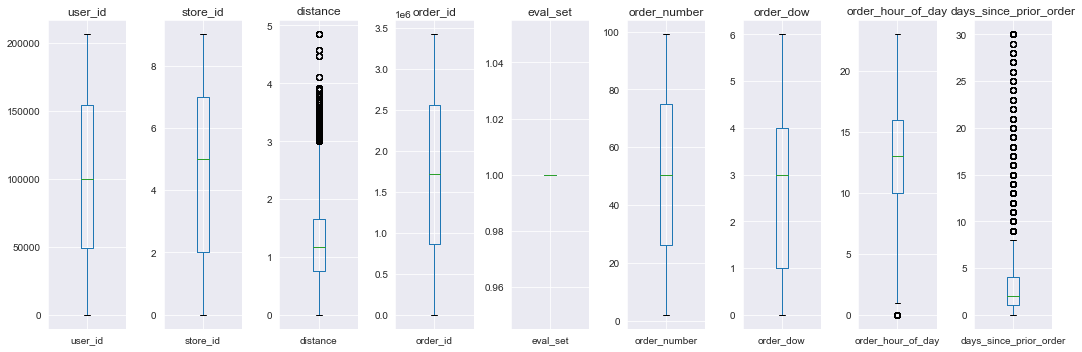

In [178]:
def detect_susceptible_outlier(data) : 
    fig, axes = plt.subplots(nrows=1, ncols=len(data.columns), figsize=(15, 5))
    for i, col in enumerate(data.columns):
        data.boxplot(column=col, ax=axes[i])
        axes[i].set_title(col)
    
    # Adjust layout
    plt.tight_layout()
    plt.show()

print("Boxplots des colonnes du dataset order_distance_stores_softmax")
detect_susceptible_outlier(data_orders_distance)

Boxplots des colonnes du dataset order_products_prior_specials


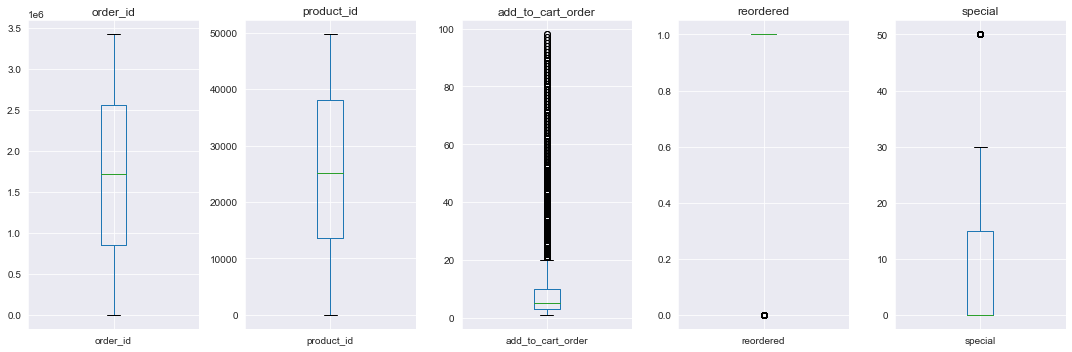

In [179]:
print("Boxplots des colonnes du dataset order_products_prior_specials")
detect_susceptible_outlier(data_orders_products)

Les attributs susceptibles d'avoir des outliers pour les données 'order_distance_stores_softmax' sont :
    + distance
    + order_hour_of_day
    + days_since_prior_order
Les attributs susceptibles d'avoir des outliers pour les données 'order_products_prior_specials' sont :
    + add_to_cart_order
    + special

Ces outliers peuvent toutefois encoder des informations importantes concernant le comportement des clients. Comme ils sont peu nombreux, nous choississons pour l'instant de les conserver dans le dataset et travaillerons dessus si les algorithmes le necessitent dans la suite

#### Intégration des données

##### Combinaison des datasets
On fusionne les datasets selon les id des commandes

In [185]:
data_orders = pd.merge(data_orders_products, data_orders_distance, on='order_id', how='inner')

In [186]:
# Vérification simple
data_orders.head()

,order_id,product_id,add_to_cart_order,reordered,special,user_id,store_id,distance,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,15,19660,1,1,15,54901,1,0.304608,1,51,3,11,2.0
1,15,21195,2,1,0,54901,1,0.304608,1,51,3,11,2.0
2,15,7461,3,1,50,54901,1,0.304608,1,51,3,11,2.0
3,15,2996,4,1,0,54901,1,0.304608,1,51,3,11,2.0
4,15,32463,5,1,0,54901,1,0.304608,1,51,3,11,2.0


#### Réduction

##### Feature engineering rapide
Bien que cela ne soit pas demandé explicitemment dans le sujet du tp, nous regardons rapidement la corrélation 2 à 2 entre les différents attributs des données afin de pouvoir éliminer d'éventuelles redondances dans ces dernière au cas où nous ayons besoin d'accélerer l'entraîenment de nos algorithmes dans la suite.

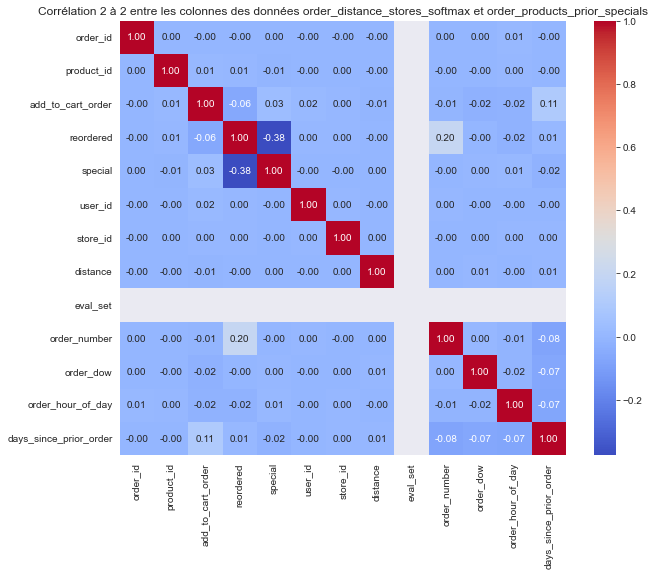

In [187]:
# Corrélation 2 à 2 pour les données order_distance_stores_softmax
correlation_matrix_orders = data_orders.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix_orders, annot=True, cmap='coolwarm', fmt=".2f", annot_kws={"size": 10})
plt.title('Corrélation 2 à 2 entre les colonnes des données order_distance_stores_softmax et order_products_prior_specials')
plt.show()

Les attributs sont très peu corrélés ou non corrélés. On gardes toutes les features pour le moment mais nous n'écartons pas la possibilité de recourir à des techniques de reduction de dimensionalité si l'entraînement des algortihmes le nécessite dans la suite.

##### Réduction des données
Nous cherchons à présent à réduire le volume de données tout en conservant le maximum d'information ainsi que des données représentatives du dataset initial.

Pour cela, nous procédons à un échantillonage probabiliste **stratifié** de nos données.
Le caractère probabiliste de l'échantillonage assure de réduire le biais lié à la selection effectuée. L'aspect stratifié assure quant à lui d'obtenir un sous-ensemble de données **représentatif de la population originelle**

In [202]:
# On stratify selon l'attribut 'reordered' qui correspond à notre cible.
from sklearn.model_selection import train_test_split

# Assuming 'target' is the column representing classes/groups
_, sampled_df = train_test_split(data_orders, test_size=0.05, stratify=data_orders['reordered'], random_state=42)

# On visualise les statistiques des données obtenues
sampled_stats = sampled_df.describe()
print(sampled_stats.columns.values)

['order_id' 'product_id' 'add_to_cart_order' 'reordered' 'special'
 'user_id' 'store_id' 'distance' 'eval_set' 'order_number' 'order_dow'
 'order_hour_of_day' 'days_since_prior_order']


In [192]:
# Visualisation des statistiques sur les données avant sampling
data_orders.describe()

,order_id,product_id,add_to_cart_order,reordered,special,user_id,store_id,distance,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
count,1.158441e+06,1.158441e+06,1.158441e+06,1.158441e+06,1.158441e+06,1.158441e+06,1.158441e+06,1.158441e+06,1158441.0,1.158441e+06,1.158441e+06,1.158441e+06,1.158441e+06
mean,1.710164e+06,2.558395e+04,7.298923e+00,7.837076e-01,9.729891e+00,1.011315e+05,4.496251e+00,1.252360e+00,1.0,5.008975e+01,2.847603e+00,1.298764e+01,3.150326e+00
std,9.866727e+05,1.403645e+04,6.642580e+00,4.117161e-01,1.496066e+01,6.051740e+04,2.858921e+00,6.572331e-01,0.0,2.874572e+01,1.916809e+00,4.247725e+00,2.730478e+00
min,1.500000e+01,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,2.100000e+02,0.000000e+00,2.863073e-03,1.0,2.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,8.561710e+05,1.357500e+04,3.000000e+00,1.000000e+00,0.000000e+00,4.918600e+04,2.000000e+00,7.634151e-01,1.0,2.500000e+01,1.000000e+00,1.000000e+01,1.000000e+00
50%,1.712683e+06,2.514600e+04,5.000000e+00,1.000000e+00,0.000000e+00,9.935200e+04,4.000000e+00,1.171138e+00,1.0,5.000000e+01,3.000000e+00,1.300000e+01,3.000000e+00
75%,2.562347e+06,3.802800e+04,1.000000e+01,1.000000e+00,1.500000e+01,1.545560e+05,7.000000e+00,1.654865e+00,1.0,7.500000e+01,4.000000e+00,1.600000e+01,4.000000e+00
max,3.421069e+06,4.968300e+04,9.800000e+01,1.000000e+00,5.000000e+01,2.061050e+05,9.000000e+00,4.843817e+00,1.0,9.900000e+01,6.000000e+00,2.300000e+01,3.000000e+01


on compare les statistiques avant et après sampling pour voir si la diversité des données est aussi bien représentée qu'avant.

In [205]:
diff_tab = []
for col_name in sampled_df.describe().columns.values:
    stat_pre_sampling = data_orders.describe()[col_name]
    stat_post_sampling = sampled_df.describe()[col_name]
    diff = 100 * abs(stat_post_sampling - stat_pre_sampling) / (stat_post_sampling + stat_pre_sampling)
    diff_tab.append(diff)
print(diff_tab)

[count    90.476042
mean      0.091231
std       0.079166
min      72.727273
25%       0.261172
50%       0.091958
75%       0.044948
max       0.000614
Name: order_id, dtype: float64, count    90.476042
mean      0.079241
std       0.154130
min       0.000000
25%       0.723428
50%       0.000000
75%       0.165393
max       0.000000
Name: product_id, dtype: float64, count    90.476042
mean      0.253914
std       0.043980
min       0.000000
25%       0.000000
50%       0.000000
75%       0.000000
max       0.000000
Name: add_to_cart_order, dtype: float64, count    90.476042
mean      0.000336
std       0.000031
min            NaN
25%       0.000000
50%       0.000000
75%       0.000000
max       0.000000
Name: reordered, dtype: float64, count    90.476042
mean      0.268139
std       0.094313
min            NaN
25%            NaN
50%            NaN
75%       0.000000
max       0.000000
Name: special, dtype: float64, count    90.476042
mean      0.325658
std       0.026031
min       0

on constate que les statistiques des distributions ont majoritairement été conservé après l'échantillonage. Cela infique que l'information et la représentativité des données a bien été conservée.

In [208]:
# sampled_df.to_csv('reduced_data.csv') Marche aps

### 1.b - Préparation des données

#### Création des ensembles d'entraînement et de test
On sépare les données en ensembles d'entraînement et de test tout en conservant la diversité des données dans chacun de ces ensembles. pour cela, on utilise l'option 'stratfied' de la fonction train_test_split de sklearn

In [224]:
X = data_orders.drop(columns=['reordered']) # datas
y = data_orders['reordered'] # targets

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, stratify=y)

#### Transformation

##### Normalisation des ensmebles d'entraîenemnt et de test
Les algorithmes que nous appliquerons par la suite (CNN et SVM) ne nécessitent pas de connaître la distribution des données.
Nous procédons donc à la normalisation des données afin de les ramener dans un intervalle connu.

In [227]:
standard_scaler = StandardScaler()
X_train_scaled = standard_scaler.fit_transform(X_train)
X_test_scaled = standard_scaler.fit_transform(X_test)

In [234]:
# Vérification
print(f"Moyenne de X_train_scaled = {X_train_scaled.mean()} et déviation standard = {X_train_scaled.std()}")
print(f"Moyenne de X_test_scaled = {X_test_scaled.mean()} et déviation standard = {X_test_scaled.std()}")

Moyenne de X_train_scaled = 1.4195490004443752e-17 et déviation standard = 0.9574271077563372
Moyenne de X_test_scaled = 4.956196767576227e-17 et déviation standard = 0.9574271077563381


A l'issu des ces étapes de prétraitement, les données ont été standardisée et peuvent être desormais utilisées dans les algorithmes suivants.